In [1]:
setwd("~/ben_lustre/current_projects/kidney_glomTI_response")
suppressPackageStartupMessages(source("https://raw.githubusercontent.com/bjstewart1/helpful_singlecell/main/functions.R"))
ad <- import("anndata")
sc <- import("scanpy")
epi <- import('episcanpy')
mu <- import("muon")
ac <- mu$atac

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


In [2]:
suppressPackageStartupMessages({
library(Signac)
library(GenomicRanges)
library(data.table)
library(EnsDb.Hsapiens.v86)
library(tidyverse)
library(data.table)
        })

Warning message in system("timedatectl", intern = TRUE):
"running command 'timedatectl' had status 1"


In [3]:
seq_inventory = read.csv("/nfs/team297/bs16/sample_donor_data/sequencing_inventory.csv")
seq_inventory = seq_inventory[seq_inventory$experiment %in% "10X_multiome_ATAC", ]
seq_inventory = seq_inventory[!seq_inventory$poor_QC, ]
seq_inventory = seq_inventory[seq_inventory$tissue %in% "kidney_single_nucleus_suspension", ]
aggregation = read.csv("./data/seq_data/10X_snATACseq/aggregation.csv")

In [4]:
fn_in = data.frame("channel" = seq_inventory$irods_ID, "ID" = seq_inventory$sanger_ID)

In [5]:
#get a genomic annotation for the reference
library(rtracklayer)
encode_dir = '~/ben_lustre/ENCODE_reference'
setwd(encode_dir)
peak_file = file.path('./DHS_ENCODE_ref_500.bed')
peaks_gr <- import(peak_file, format="bed")
EnsDb.genome = EnsDb.Hsapiens.v86
blacklist_gr = Signac::blacklist_hg38
#get width
peaks_gr$peak_width <- width(peaks_gr)
#annotate the blacklist
overlaps <- findOverlaps(peaks_gr, blacklist_gr, minoverlap = 10)
anno_name= 'blacklist'
peaks_gr@elementMetadata[anno_name] <- 0
peaks_gr@elementMetadata[anno_name][queryHits(overlaps),] <- 1
#make the var the peak data
peaks_df = data.frame(
    paste0(peaks_gr@seqnames, ":", peaks_gr@ranges),
    peaks_gr@ranges, 
    peaks_gr@seqnames,
    peaks_gr@elementMetadata$blacklist)
colnames(peaks_df) = c("peak_id","start" , "end", "peak_width","seqnames" ,
                       "blacklist")


Attaching package: 'rtracklayer'


The following object is masked from 'package:igraph':

    blocks


The following object is masked from 'package:reticulate':

    import




In [6]:
atac_dir = '~/ben_lustre/current_projects/kidney_glomTI_response/data/seq_data/10X_multiome'
setwd(atac_dir)
#arrow adata
arrow_dir = '~/ben_lustre/current_projects/kidney_glomTI_response/data/raw/10X_multiome/archR_files'

read_in_channels = function(x){
    
        ch = fn_in[x, 'channel']
        id = fn_in[x, 'ID']
        message(ch)
        fname = file.path(ch, "bustools_out_500", "output.mtx")
        adata = sc$read_mtx(fname)
        message("matrix inputted")
        barcodes_filename = file.path(ch, "bustools_out_500/output.barcodes.txt")
        barcodes = paste0(read.table(barcodes_filename, header = FALSE)[, 1], "-1")
        adata$obs_names = barcodes
        adata$obs$channel = ch
        #set the adata names to gex barcodes for consistency
        pbm = read.csv(file.path(atac_dir, ch, "per_barcode_metrics.csv"), row.names = 3) #set rownames as atac barcodes
        pbm = pbm[adata$obs_names$values, ]
        dim(pbm)
        adata$obs$barcode = adata$obs$gex_barcode = pbm$gex_barcode
        adata$obs$atac_barcode = adata$obs_names$values
    #subset to cells
        filtered_barcodes = read.csv(file.path(ch, 'filtered_feature_bc_matrix', 'barcodes.tsv.gz' ), header = FALSE)[, 1]
        adata = adata[adata$obs$gex_barcode %in% filtered_barcodes]        
    #sort out the metadata
        metadata = seq_inventory
        rownames(metadata) <- metadata$irods_ID
        adata$obs <- cbind(adata$obs, metadata[adata$obs$channel, ])
        #set obs names
        adata$obs_names = paste0(adata$obs$sanger_ID, "_", adata$obs$barcode)
    
        #read in the tilematrix adata
        setwd(arrow_dir)
        message("reading tilematrix")
        arrow_adata= sc$read_h5ad(paste0(id, '.TileMatrix.h5ad'))
        setwd(atac_dir)
        #make the barcode the gex barcode
        arrow_adata$obs$barcode = arrow_adata$obs$CellNames
        arrow_adata$obs$channel = id
        #set obs names
        arrow_adata$obs_names = paste0(arrow_adata$obs$channel, "_", arrow_adata$obs$barcode)
        arrow_df = arrow_adata$obs[, c(1, 3:ncol(arrow_adata$obs))] #we just want the metadata from the arrow file..
        rownames(arrow_df) = arrow_adata$obs_names$values
    
        rm(arrow_adata)
        gc()

    #filter and add arrow info
        adata = adata[adata$obs_names$values %in% rownames(arrow_df)] #subset to filtered cells.
        arrow_df = arrow_df[adata$obs_names$values, ]
        adata$obs = cbind(adata$obs, arrow_df) #we are just adding the metadata here     

    #features
        features_path = file.path(ch, "bustools_out_500/output.genes.txt")
        features = read.table(features_path, header = FALSE)[, 1]
        adata$var_names = features
    
    #add the cell assignments
        message("adding cell assignments")
        cell_assignments <- readRDS("~/ben_lustre/current_projects/kidney_glomTI_response/data/genotypes/cell_assignments_nuclei.RDS")
        cell_assignments$cbarcode = paste0(cell_assignments$channel, "_", cell_assignments$barcode)
        rownames(cell_assignments) = cell_assignments$cbarcode
        cell_assignments = cell_assignments[cell_assignments$channel %in% unique(adata$obs$sanger_ID), ]
        cell_assignments = cell_assignments[adata$obs_names$values, ]
        #add to obs 
        adata$obs <- cbind(adata$obs, cell_assignments[, c(2,3,5,6)])
        #subset to included - ie. called cells.
        adata = adata[!adata$obs$status %in% "NA"]
        #remove unassigned
        adata = adata[!adata$obs$status %in% "unassigned"]


    #add in some donor demographics ####
        message("adding demographics")
        donor_demographics <- read.csv("~/ben_nfs/sample_donor_data/donor_demographics.csv", row.names = 1)
        donor_demographics <- donor_demographics[adata$obs$genotype, ]
        adata$obs <- cbind(adata$obs, donor_demographics) #bind this to adata$obs - this will result in NAs but we will remove the doublets in due cours
    
    #add in the amulet doublets
        amulets_multiplets = read.csv(file.path(atac_dir, 
                                        ch, 
                                        'amulet_output', 'MultipletCellIds_01.txt'), 
                              header = FALSE, sep = '\t')[,1]
        adata$obs$amulet_doublet = adata$obs$barcode %in% amulets_multiplets


return(adata)

}

In [7]:
#read in each channel in turn
adata_list  = lapply(1:nrow(fn_in),  read_in_channels)

cellranger-arc200_count_01cd0b1f038cca6db6a3172cce92d8b2

matrix inputted

reading tilematrix

adding cell assignments

adding demographics

cellranger-arc200_count_426421b13676b7ad1ab64607030fd992

matrix inputted

reading tilematrix

adding cell assignments

adding demographics

cellranger-arc200_count_ab64b7249f90c1a7b6b45a07813a6628

matrix inputted

reading tilematrix

adding cell assignments

adding demographics

cellranger-arc200_count_a7a1cc9612bab77c305d5f44b7fd527b

matrix inputted

reading tilematrix

adding cell assignments

adding demographics

cellranger-arc200_count_01bf5eb88f1fd6261cd273821e27ec62

matrix inputted

reading tilematrix

adding cell assignments

adding demographics

cellranger-arc200_count_ffb2d458cc939df2f22324fd3a5f9e66

matrix inputted

reading tilematrix

adding cell assignments

adding demographics

cellranger-arc200_count_4cf593ecccbf5c8b4fbe80bb80a48bef

matrix inputted

reading tilematrix

adding cell assignments

adding demographics

cellranger-ar

In [8]:
#remove duplicated column names from obs
adata_list = lapply(adata_list, function(adata){
    adata$obs = adata$obs[, !duplicated(colnames(adata$obs))]
                         return(adata)})

In [9]:
adata = sc$concat(adata_list)

In [10]:
adata$var = cbind(adata$var, peaks_df)

In [11]:
#add in depth information ####
depth_data <- read.csv("~/nfs/team297/bs16/sample_donor_data/multiome_depths.csv")
depth_data <- reshape2::melt(depth_data)
adata$obs$depth <- adata$obs$anatomy
adata$obs$depth[adata$obs$irods_ID %in% unique(depth_data$Channel)] <- "depth_doublet"
for(i in seq_along(rownames(depth_data))){
  dpths <- depth_data[i, ]
  message(dpths$Channel)
  adata$obs$depth[adata$obs$genotype %in% dpths$variable & adata$obs$irods_ID %in% dpths$Channel] <- dpths$value
}

Using Channel as id variables

cellranger-arc200_count_01cd0b1f038cca6db6a3172cce92d8b2

cellranger-arc200_count_426421b13676b7ad1ab64607030fd992

cellranger-arc200_count_ab64b7249f90c1a7b6b45a07813a6628

cellranger-arc200_count_a7a1cc9612bab77c305d5f44b7fd527b

cellranger-arc200_count_01bf5eb88f1fd6261cd273821e27ec62

cellranger-arc200_count_ffb2d458cc939df2f22324fd3a5f9e66

cellranger-arc200_count_4cf593ecccbf5c8b4fbe80bb80a48bef

cellranger-arc200_count_74321fba0e783fce0013e58e85e71d44

cellranger-arc200_count_8e59d6e5b9b4a25a7bbc7bb2467ecfab

cellranger-arc200_count_6c2252bc28c267c2b3e6e944af693fdc

cellranger-arc200_count_f4b032abc513453fee40a6bd05fe1c84

cellranger-arc200_count_45b1a41724921d5ae562e15580bf2243

cellranger-arc200_count_01cd0b1f038cca6db6a3172cce92d8b2

cellranger-arc200_count_426421b13676b7ad1ab64607030fd992

cellranger-arc200_count_ab64b7249f90c1a7b6b45a07813a6628

cellranger-arc200_count_a7a1cc9612bab77c305d5f44b7fd527b

cellranger-arc200_count_01bf5eb88f1fd6261

In [12]:
#regions to exclude
adata$var['MT'] = adata$var$seqnames %in% 'chrM'
adata$var['BLK'] = adata$var$blacklist == 1
sc$pp$calculate_qc_metrics(adata, log1p=TRUE, inplace=TRUE, qc_vars=list('MT', 'BLK'))

In [13]:
adata

AnnData object with n_obs × n_vars = 104401 × 1063709
    obs: 'channel', 'gex_barcode', 'barcode', 'atac_barcode', 'donor', 'date', 'submission_channel', 'sequencing_sample_name', 'sanger_ID', 'tissue', 'poor_QC', 'experiment', 'tissue_dissociation_processing_batch', 'sequencing_batch', 'n_genotypes', 'anatomy', 'sanger_study', 'source', 'tissue_process', 'perturbation_timepoint', 'age', 'sex', 'CASM_ID', 'Status', 'cellranger_SOC', 'HMDMC', 'irods_dir', 'irods_ID', 'X10xDIR', 'BlacklistRatio', 'NucleosomeRatio', 'PassQC', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'TSSEnrichment', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'status', 'assignment', 'genotype', 'SOC_cluster', 'tissue_type', 'laterality', 'donor_age', 'donor_sex', 'CIT_at_processing', 'fresh.frozen', 'perfused', 'transplant_detail', 'admission_creatinine', 'last_creatinine', 'amulet_doublet', 'depth', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 

Loading required package: ggrastr

Loading required package: MASS


Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select


The following object is masked from 'package:ensembldb':

    select


The following object is masked from 'package:AnnotationDbi':

    select




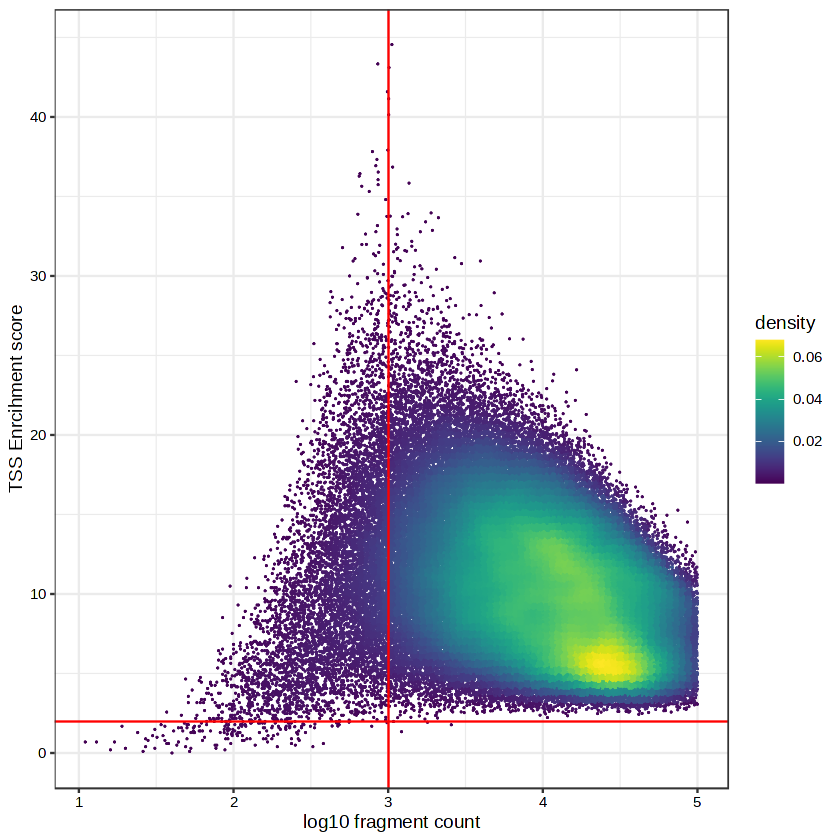

In [14]:
log10_n_fragment_cutoff  = 3
TSS_enrichment_cutoff =2

density_plot_raster(x = log10(adata$obs$nFrags), y = adata$obs$TSSEnrichment) + 
xlab("log10 fragment count") + ylab("TSS Enrcihment score") + geom_vline(xintercept = log10_n_fragment_cutoff, color = 'red' ) + 
geom_hline(yintercept = TSS_enrichment_cutoff, color = 'red')

In [15]:
#do the cut
nfrag_cut = log10(adata$obs$'nFrags') > log10_n_fragment_cutoff
tss_cut =adata$obs$'TSSEnrichment' > TSS_enrichment_cutoff
adata = adata[tss_cut & nfrag_cut]
adata

View of AnnData object with n_obs × n_vars = 96674 × 1063709
    obs: 'channel', 'gex_barcode', 'barcode', 'atac_barcode', 'donor', 'date', 'submission_channel', 'sequencing_sample_name', 'sanger_ID', 'tissue', 'poor_QC', 'experiment', 'tissue_dissociation_processing_batch', 'sequencing_batch', 'n_genotypes', 'anatomy', 'sanger_study', 'source', 'tissue_process', 'perturbation_timepoint', 'age', 'sex', 'CASM_ID', 'Status', 'cellranger_SOC', 'HMDMC', 'irods_dir', 'irods_ID', 'X10xDIR', 'BlacklistRatio', 'NucleosomeRatio', 'PassQC', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'TSSEnrichment', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'status', 'assignment', 'genotype', 'SOC_cluster', 'tissue_type', 'laterality', 'donor_age', 'donor_sex', 'CIT_at_processing', 'fresh.frozen', 'perfused', 'transplant_detail', 'admission_creatinine', 'last_creatinine', 'amulet_doublet', 'depth', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_co

In [16]:
#do a cutoff...

In [17]:
#filter blacklist, MT, and Y
adata = py_eval('r.adata[:, r.adata.var.blacklist == 0]')
adata = py_eval('r.adata[:, ~r.adata.var.seqnames.isin(["chrM"])]')
adata = py_eval('r.adata[:, ~r.adata.var.seqnames.isin(["chrY"])]')

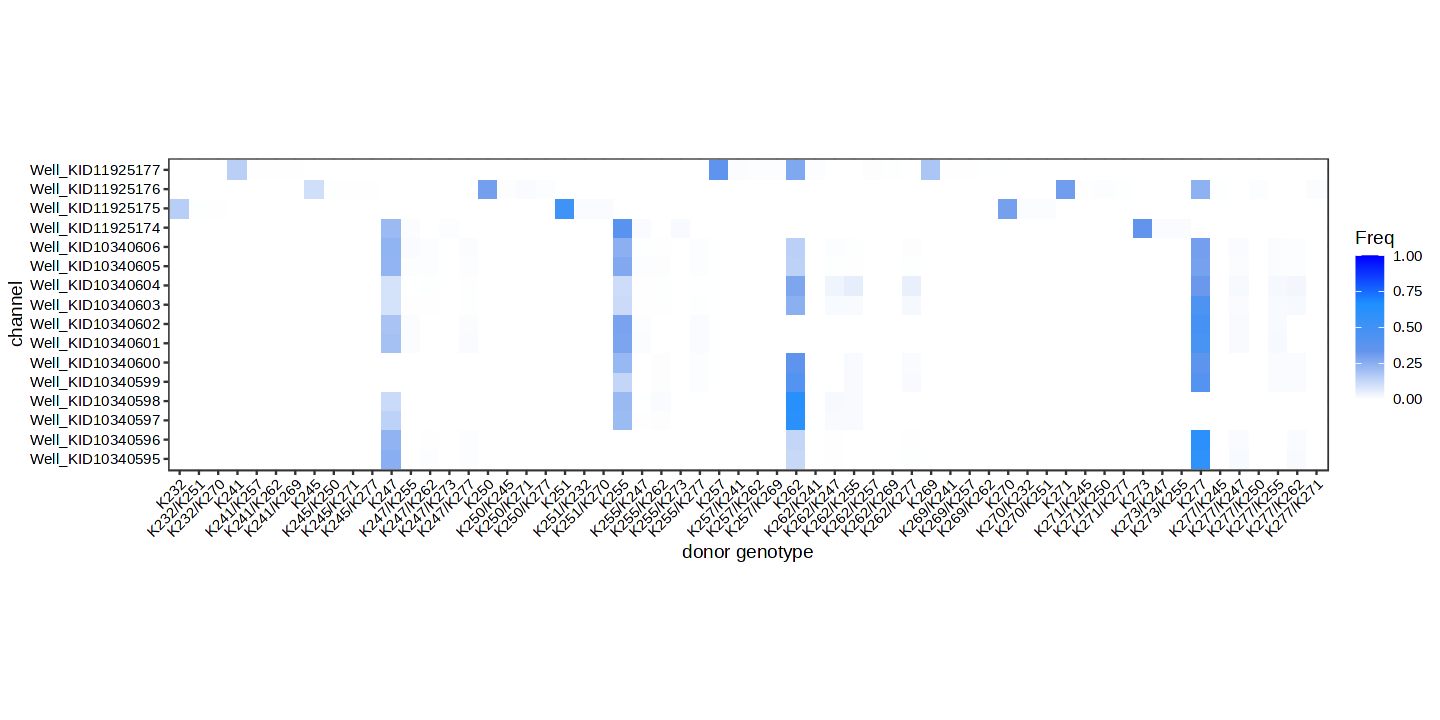

In [18]:
options(repr.plot.width = 12, repr.plot.height = 6)
ggplot(data.frame(table(adata$obs$channel, adata$obs$genotype)/rowSums(table(adata$obs$channel, adata$obs$genotype))), aes(x=Var2, y=Var1, fill = Freq)) + 
geom_tile() + coord_fixed() + 
scale_fill_gradientn(colors = colorRampPalette(c("white", "cornflowerblue", "dodgerblue", "blue"))(200), limits = c(0,1)) + xlab("donor genotype") + ylab("channel") + theme_bw() + 
theme(axis.text.x = element_text(angle = 45, hjust = 1, color = 'black'), axis.text.y = element_text(color = 'black'))

In [19]:
atac_dir = '~/ben_lustre/current_projects/kidney_glomTI_response/data/raw/10X_multiome'
setwd(atac_dir)

In [20]:
adata$write('./multiome_atac_raw.h5ad')